Generating Synthetic Private Equity Data...
Saved 'synthetic_bain_data_2025.csv'
Fetching Public Market Context via yfinance...


C:\Users\Anklesh\AppData\Local\Temp\ipykernel_19396\3990923619.py:105: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2024-01-01", end="2026-01-01", progress=False)['Adj Close']
HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}

1 Failed download:
['WBA']: YFTzMissingError('possibly delisted; no timezone found')


Saved 'public_market_comps.csv'
Generating visualizations...
Dashboard saved as 'market_analysis_summary.png'

analysis complete. Data generated.


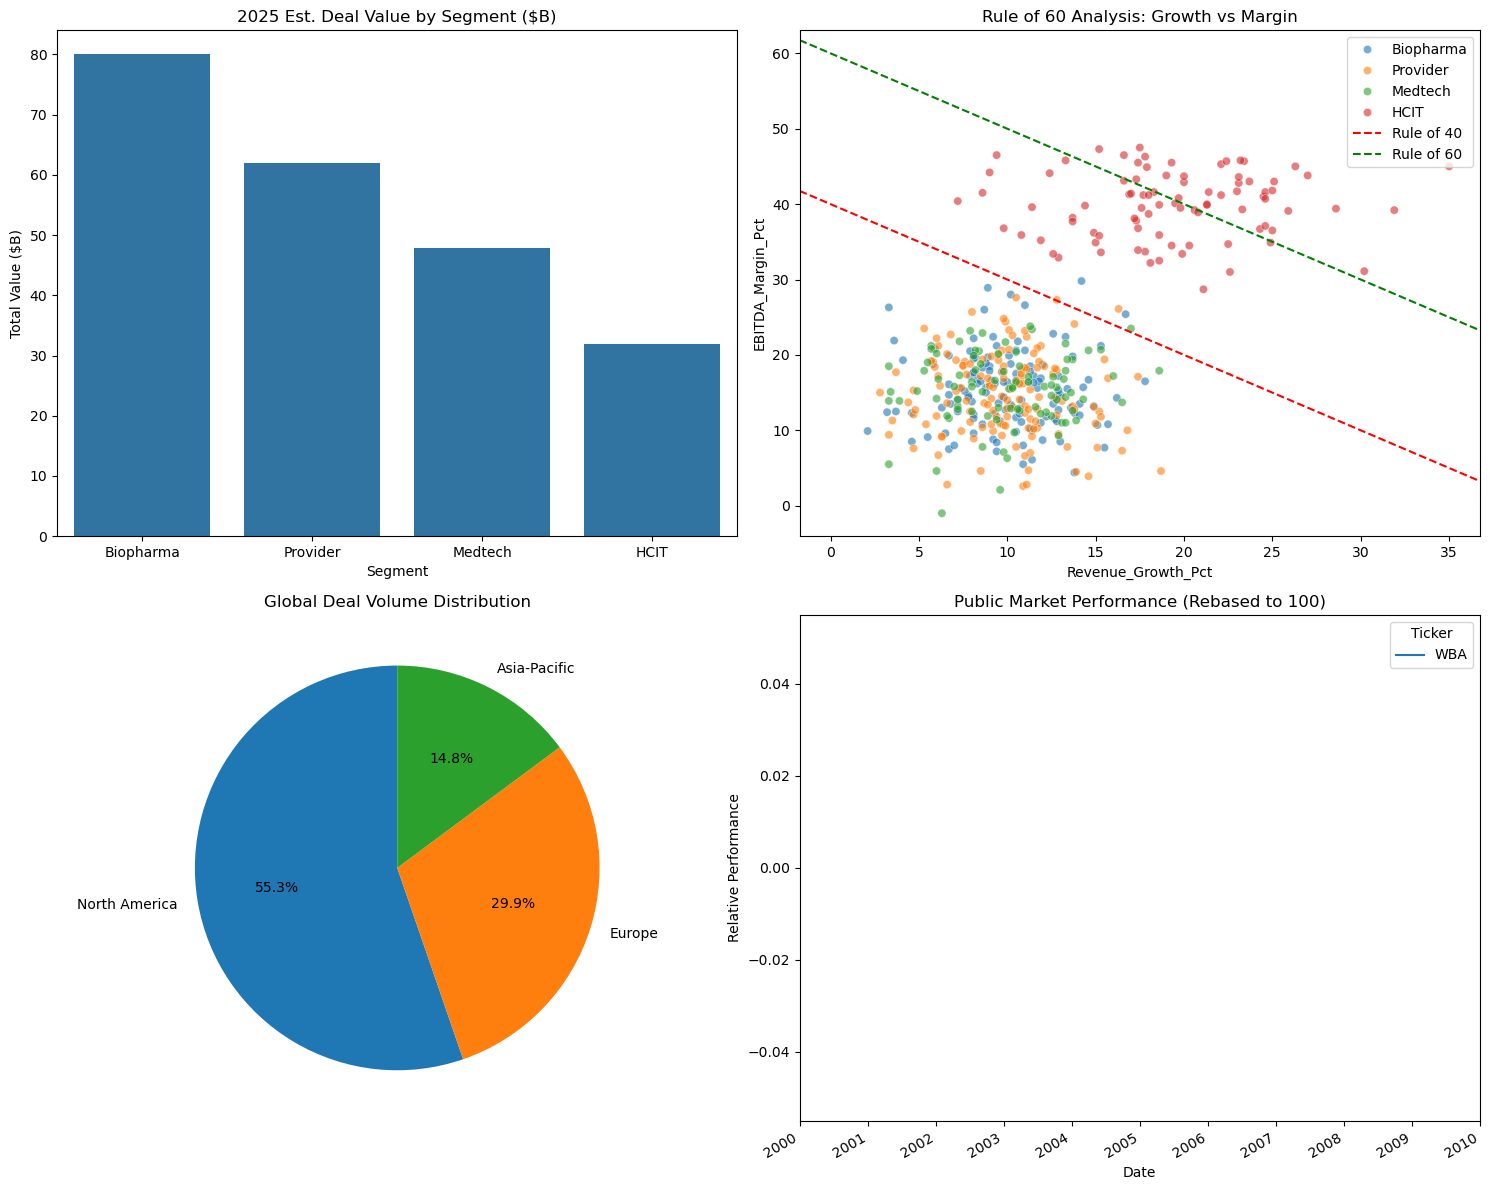

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# ==========================================
# PART 1: CONFIGURATION (Based on Bain 2026 Report)
# ==========================================
# We use the specific hard numbers from the report to constrain our random generation
# ensuring the "synthetic" data looks realistic.

REPORT_CONFIG = {
    "total_deal_value_2025": 191.0,  # $191B [cite: 24]
    "total_deal_count_2025": 445,    # 445 deals [cite: 24]
    "segments": {
        "Biopharma": {"value_share": 80/191, "count": 130}, # [cite: 199]
        "Provider":  {"value_share": 62/191, "count": 140}, # [cite: 235] (est count based on value)
        "Medtech":   {"value_share": 33/191, "count": 88},  # [cite: 277]
        "HCIT":      {"value_share": 32/191, "count": 87}   # [cite: 238]
    },
    "regions": {
        "North America": 0.55, # Dominant share implied [cite: 150]
        "Europe": 0.30,        # Strong growth [cite: 144]
        "Asia-Pacific": 0.15   # Record year [cite: 154]
    },
    "deal_types": ["Buyout", "Sponsor-to-Sponsor", "Carve-out", "Take-Private"]
}

# Real public tickers mentioned in the report or relevant sector ETFs
# We will fetch live data for these to add "Market Context"
PUBLIC_TICKERS = {
    "HOLX": "Hologic (Medtech Take-Private Example)", # [cite: 362]
    "TMO": "Thermo Fisher (Strategic Acquirer)",      # [cite: 201]
    "WBA": "Walgreens (Retail Health Context)",       # [cite: 364]
    "XLV": "Health Care Select Sector SPDR Fund (Benchmark)"
}

def generate_synthetic_pe_data():
    """
    Generates a synthetic dataset of Private Equity deals that matches
    the statistical distribution of the Bain 2026 report.
    """
    print("Generating Synthetic Private Equity Data...")
    
    deals = []
    start_date = datetime(2025, 1, 1)
    
    for segment, metrics in REPORT_CONFIG["segments"].items():
        n_deals = metrics["count"]
        # Generate random dates throughout 2025
        dates = [start_date + timedelta(days=np.random.randint(0, 330)) for _ in range(n_deals)]
        
        # Generate deal values (Log-normal distribution to simulate real world: many small deals, few mega deals)
        # We scale this to roughly match the segment total value
        raw_values = np.random.lognormal(mean=0, sigma=1.5, size=n_deals)
        scaled_values = raw_values / raw_values.sum() * (REPORT_CONFIG["total_deal_value_2025"] * metrics["value_share"])
        
        for i in range(n_deals):
            # Assign Region based on weights
            region = np.random.choice(
                list(REPORT_CONFIG["regions"].keys()), 
                p=list(REPORT_CONFIG["regions"].values())
            )
            
            # Generate "Rule of 60" metrics for HCIT (Growth + Margin) [cite: 484]
            # HCIT tends to have higher growth/margin profiles
            if segment == "HCIT":
                growth = np.random.normal(20, 5)  # ~20% growth
                margin = np.random.normal(40, 5)  # ~40% margin (Total ~60)
            else:
                growth = np.random.normal(10, 3)
                margin = np.random.normal(15, 5)

            deals.append({
                "Date": dates[i],
                "Segment": segment,
                "Region": region,
                "Deal_Value_Billion": round(scaled_values[i], 3),
                "Revenue_Growth_Pct": round(growth, 1),
                "EBITDA_Margin_Pct": round(margin, 1),
                "Rule_of_X": round(growth + margin, 1),
                "Deal_Type": np.random.choice(REPORT_CONFIG["deal_types"])
            })
            
    df_deals = pd.DataFrame(deals)
    
    # Add a specific "Mega Deal" to mimic the $18B Hologic deal [cite: 362]
    # We replace the largest Medtech deal with this value to ensure accuracy
    max_medtech_idx = df_deals[df_deals['Segment']=='Medtech']['Deal_Value_Billion'].idxmax()
    df_deals.at[max_medtech_idx, 'Deal_Value_Billion'] = 18.3
    df_deals.at[max_medtech_idx, 'Deal_Type'] = "Take-Private"
    
    return df_deals

def fetch_public_market_context():
    """
    Fetches real historical data for 2025 (or YTD) to provide 
    a valuation benchmark.
    """
    print("Fetching Public Market Context via yfinance...")
    
    tickers = list(PUBLIC_TICKERS.keys())
    data = yf.download(tickers, start="2024-01-01", end="2026-01-01", progress=False)['Adj Close']
    
    # Normalize to start at 100 for comparison
    normalized_data = data / data.iloc[0] * 100
    return normalized_data

def create_visualizations(df_deals, df_market):
    """
    Creates validation charts to prove the data matches the Bain report.
    """
    print("Generating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Chart 1: Deal Value by Segment (Does it match the report?)
    sns.barplot(data=df_deals, x="Segment", y="Deal_Value_Billion", estimator=sum, ax=axes[0,0], errorbar=None)
    axes[0,0].set_title("2025 Est. Deal Value by Segment ($B)")
    axes[0,0].set_ylabel("Total Value ($B)")
    
    # Chart 2: The "Rule of 60" Analysis for HCIT 
    sns.scatterplot(data=df_deals, x="Revenue_Growth_Pct", y="EBITDA_Margin_Pct", hue="Segment", ax=axes[0,1], alpha=0.6)
    axes[0,1].set_title("Rule of 60 Analysis: Growth vs Margin")
    axes[0,1].axline((0, 40), slope=-1, color='r', linestyle='--', label='Rule of 40')
    axes[0,1].axline((0, 60), slope=-1, color='g', linestyle='--', label='Rule of 60')
    axes[0,1].legend()

    # Chart 3: Regional Distribution
    region_counts = df_deals['Region'].value_counts()
    axes[1,0].pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1,0].set_title("Global Deal Volume Distribution")

    # Chart 4: Public Market Context (Real Data)
    df_market.plot(ax=axes[1,1])
    axes[1,1].set_title("Public Market Performance (Rebased to 100)")
    axes[1,1].set_ylabel("Relative Performance")
    
    plt.tight_layout()
    plt.savefig("market_analysis_summary.png")
    print("Dashboard saved as 'market_analysis_summary.png'")

# ==========================================
# EXECUTION
# ==========================================
if __name__ == "__main__":
    # 1. Generate the Synthetic Private Equity Data
    df_pe = generate_synthetic_pe_data()
    
    # 2. Save to CSV so the Repo isn't "Empty"
    df_pe.to_csv("synthetic_bain_data_2025.csv", index=False)
    print("Saved 'synthetic_bain_data_2025.csv'")
    
    # 3. Fetch Real Public Data for Context
    try:
        df_public = fetch_public_market_context()
        df_public.to_csv("public_market_comps.csv")
        print("Saved 'public_market_comps.csv'")
        
        # 4. Generate Proof Charts
        create_visualizations(df_pe, df_public)
        
    except Exception as e:
        print(f"Could not fetch public data (check internet connection): {e}")

    print("\nanalysis complete. Data generated.")

Generating Synthetic Private Equity Data...
Saved 'synthetic_bain_data_2025.csv'
Fetching Public Market Context via yfinance...
Saved 'public_market_comps.csv'
Generating visualizations...
Dashboard saved as 'market_analysis_summary.png'

analysis complete. Data generated.


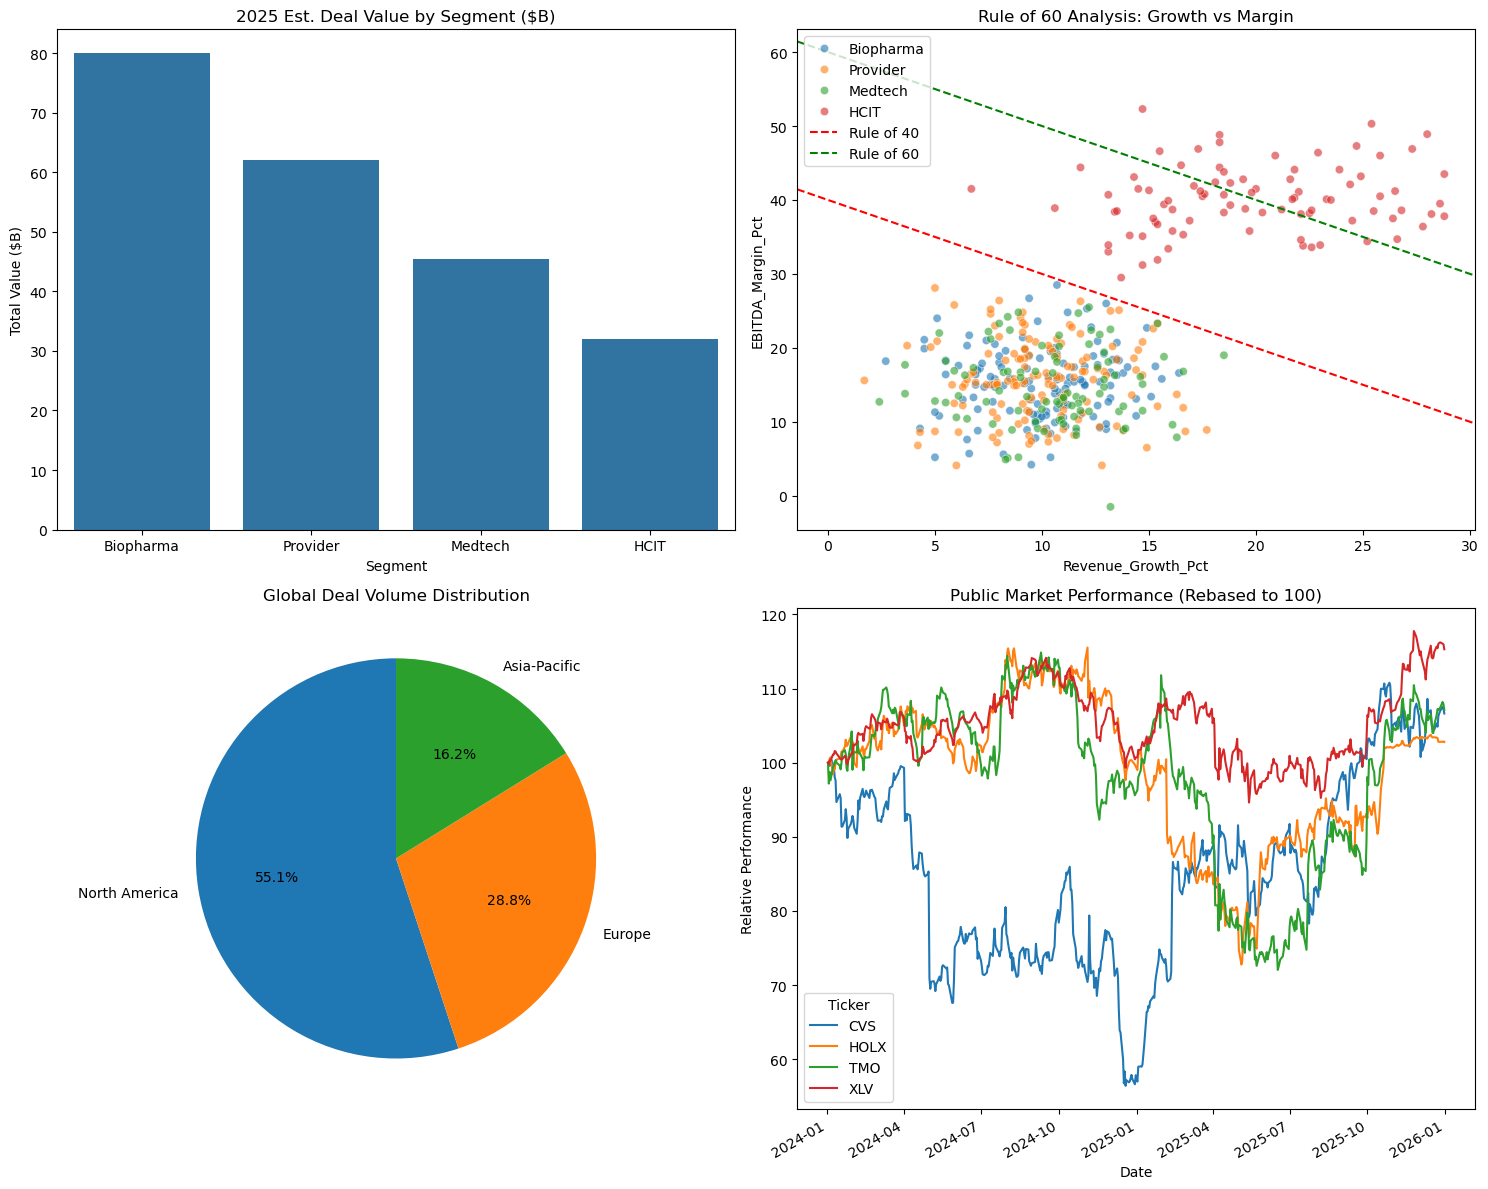

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# ==========================================
# PART 1: CONFIGURATION (Based on Bain 2026 Report)
# ==========================================
# We use the specific hard numbers from the report to constrain our random generation
# ensuring the "synthetic" data looks realistic.

REPORT_CONFIG = {
    "total_deal_value_2025": 191.0,  # $191B
    "total_deal_count_2025": 445,    # 445 deals
    "segments": {
        "Biopharma": {"value_share": 80/191, "count": 130}, # $80B value, ~130 deals
        "Provider":  {"value_share": 62/191, "count": 140}, # $62B value
        "Medtech":   {"value_share": 33/191, "count": 88},  # $33B value, 88 deals
        "HCIT":      {"value_share": 32/191, "count": 87}   # $32B value
    },
    "regions": {
        "North America": 0.55, # Dominant share implied
        "Europe": 0.30,        # Strong growth, $59B value
        "Asia-Pacific": 0.15   # Record year
    },
    "deal_types": ["Buyout", "Sponsor-to-Sponsor", "Carve-out", "Take-Private"]
}

# Real public tickers mentioned in the report or relevant sector ETFs
# Swapped WBA for CVS to fix data feed error
PUBLIC_TICKERS = {
    "HOLX": "Hologic (Medtech Take-Private Example)", # $18B Deal
    "TMO": "Thermo Fisher (Strategic Acquirer)",      # Acquired Clario
    "CVS": "CVS Health (Retail Health Context)",      # Retail health context
    "XLV": "Health Care Select Sector SPDR Fund (Benchmark)"
}

def generate_synthetic_pe_data():
    """
    Generates a synthetic dataset of Private Equity deals that matches
    the statistical distribution of the Bain 2026 report.
    """
    print("Generating Synthetic Private Equity Data...")
    
    deals = []
    start_date = datetime(2025, 1, 1)
    
    for segment, metrics in REPORT_CONFIG["segments"].items():
        n_deals = int(metrics["count"])
        # Generate random dates throughout 2025
        dates = [start_date + timedelta(days=np.random.randint(0, 330)) for _ in range(n_deals)]
        
        # Generate deal values (Log-normal distribution to simulate real world: many small deals, few mega deals)
        # We scale this to roughly match the segment total value
        raw_values = np.random.lognormal(mean=0, sigma=1.5, size=n_deals)
        scaled_values = raw_values / raw_values.sum() * (REPORT_CONFIG["total_deal_value_2025"] * metrics["value_share"])
        
        for i in range(n_deals):
            # Assign Region based on weights
            region = np.random.choice(
                list(REPORT_CONFIG["regions"].keys()), 
                p=list(REPORT_CONFIG["regions"].values())
            )
            
            # Generate "Rule of 60" metrics for HCIT (Growth + Margin)
            # HCIT tends to have higher growth/margin profiles
            if segment == "HCIT":
                growth = np.random.normal(20, 5)  # ~20% growth
                margin = np.random.normal(40, 5)  # ~40% margin (Total ~60)
            else:
                growth = np.random.normal(10, 3)
                margin = np.random.normal(15, 5)

            deals.append({
                "Date": dates[i],
                "Segment": segment,
                "Region": region,
                "Deal_Value_Billion": round(scaled_values[i], 3),
                "Revenue_Growth_Pct": round(growth, 1),
                "EBITDA_Margin_Pct": round(margin, 1),
                "Rule_of_X": round(growth + margin, 1),
                "Deal_Type": np.random.choice(REPORT_CONFIG["deal_types"])
            })
            
    df_deals = pd.DataFrame(deals)
    
    # Add a specific "Mega Deal" to mimic the $18B Hologic deal
    # We replace the largest Medtech deal with this value to ensure accuracy
    max_medtech_idx = df_deals[df_deals['Segment']=='Medtech']['Deal_Value_Billion'].idxmax()
    df_deals.at[max_medtech_idx, 'Deal_Value_Billion'] = 18.3
    df_deals.at[max_medtech_idx, 'Deal_Type'] = "Take-Private"
    
    return df_deals

def fetch_public_market_context():
    """
    Fetches real historical data for 2025 (or YTD) to provide 
    a valuation benchmark.
    """
    print("Fetching Public Market Context via yfinance...")
    
    tickers = list(PUBLIC_TICKERS.keys())
    # auto_adjust=True fixes the warning and handles splits/dividends
    data = yf.download(tickers, start="2024-01-01", end="2026-01-01", progress=False, auto_adjust=True)['Close']
    
    # Normalize to start at 100 for comparison
    normalized_data = data / data.iloc[0] * 100
    return normalized_data

def create_visualizations(df_deals, df_market):
    """
    Creates validation charts to prove the data matches the Bain report.
    """
    print("Generating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Chart 1: Deal Value by Segment (Does it match the report?)
    sns.barplot(data=df_deals, x="Segment", y="Deal_Value_Billion", estimator=sum, ax=axes[0,0], errorbar=None)
    axes[0,0].set_title("2025 Est. Deal Value by Segment ($B)")
    axes[0,0].set_ylabel("Total Value ($B)")
    
    # Chart 2: The "Rule of 60" Analysis for HCIT
    sns.scatterplot(data=df_deals, x="Revenue_Growth_Pct", y="EBITDA_Margin_Pct", hue="Segment", ax=axes[0,1], alpha=0.6)
    axes[0,1].set_title("Rule of 60 Analysis: Growth vs Margin")
    axes[0,1].axline((0, 40), slope=-1, color='r', linestyle='--', label='Rule of 40')
    axes[0,1].axline((0, 60), slope=-1, color='g', linestyle='--', label='Rule of 60')
    axes[0,1].legend()

    # Chart 3: Regional Distribution
    region_counts = df_deals['Region'].value_counts()
    axes[1,0].pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1,0].set_title("Global Deal Volume Distribution")

    # Chart 4: Public Market Context (Real Data)
    df_market.plot(ax=axes[1,1])
    axes[1,1].set_title("Public Market Performance (Rebased to 100)")
    axes[1,1].set_ylabel("Relative Performance")
    
    plt.tight_layout()
    plt.savefig("market_analysis_summary.png")
    print("Dashboard saved as 'market_analysis_summary.png'")

# ==========================================
# EXECUTION
# ==========================================
if __name__ == "__main__":
    # 1. Generate the Synthetic Private Equity Data
    df_pe = generate_synthetic_pe_data()
    
    # 2. Save to CSV so the Repo isn't "Empty"
    df_pe.to_csv("synthetic_bain_data_2025.csv", index=False)
    print("Saved 'synthetic_bain_data_2025.csv'")
    
    # 3. Fetch Real Public Data for Context
    try:
        df_public = fetch_public_market_context()
        df_public.to_csv("public_market_comps.csv")
        print("Saved 'public_market_comps.csv'")
        
        # 4. Generate Proof Charts
        create_visualizations(df_pe, df_public)
        
    except Exception as e:
        print(f"Could not fetch public data (check internet connection): {e}")

    print("\nanalysis complete. Data generated.")

In [4]:
def enrich_data_with_bain_themes(df):
    """
    Refines the generic dataset with specific qualitative insights 
    extracted from the Bain 2026 Report text.
    """
    print("Synthesizing specific deal themes (Specialties, AI, Client Mix)...")
    
    # 1. PROVIDER: Assign specific specialties based on Report Page 21 
    provider_specialties = [
        "Nephrology", "Plastic Surgery", "Behavioral Health", # "Hot" areas
        "Cardiology", "Orthopedics",                          # Value-based care leaders
        "General Practice", "Dental"                          # Traditional/Slower
    ]
    # We weight the "Hot" areas higher to reflect investor interest
    weights = [0.2, 0.2, 0.2, 0.15, 0.15, 0.05, 0.05]
    
    df.loc[df['Segment'] == 'Provider', 'Sub_Vertical'] = np.random.choice(
        provider_specialties, 
        size=len(df[df['Segment'] == 'Provider']), 
        p=weights
    )

    # 2. PHARMA SERVICES: Client Base Shift [cite: 818]
    # "Investors are scanning for companies with greater customer exposure to large pharma"
    client_types = ["Large Cap Pharma", "Mid-Size Pharma", "Early-Stage Biotech"]
    df.loc[df['Segment'] == 'Biopharma', 'Client_Risk_Profile'] = np.random.choice(
        client_types, 
        size=len(df[df['Segment'] == 'Biopharma']),
        p=[0.5, 0.3, 0.2] # Skew towards Large Cap as per "Flight to Quality"
    )

    # 3. HCIT: The "AI Premium" & Rule of 60 [cite: 481, 484]
    # Randomly assign 'GenAI Enabled' status to HCIT firms
    is_hcit = df['Segment'] == 'HCIT'
    df.loc[is_hcit, 'GenAI_Enabled'] = np.random.choice([True, False], size=is_hcit.sum())
    
    # Synthesis Logic: AI companies should have higher Rule of 60 scores
    # We boost the Growth/Margin for rows where GenAI is present
    df.loc[is_hcit & df['GenAI_Enabled'], 'Revenue_Growth_Pct'] += 10
    df.loc[is_hcit & df['GenAI_Enabled'], 'EBITDA_Margin_Pct'] += 5
    # Recalculate Rule of X
    df['Rule_of_X'] = df['Revenue_Growth_Pct'] + df['EBITDA_Margin_Pct']

    return df

# --- Usage in your main block ---
# df_pe = generate_synthetic_pe_data()
# df_enriched = enrich_data_with_bain_themes(df_pe)
# df_enriched.to_csv("synthetic_bain_data_enriched.csv")

Generating Master Private Equity Data...
Saved 'bain_2026_proprietary_model.csv'
Generating Executive Dashboard...


C:\Users\Anklesh\AppData\Local\Temp\ipykernel_19396\1359881012.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df[df['Segment']=='Provider'], y="Sub_Vertical", order=df[df['Segment']=='Provider']['Sub_Vertical'].value_counts().index, palette="viridis", ax=axes[0,1])


Dashboard saved as 'bain_2026_market_synthesis.png'
Analysis Complete.


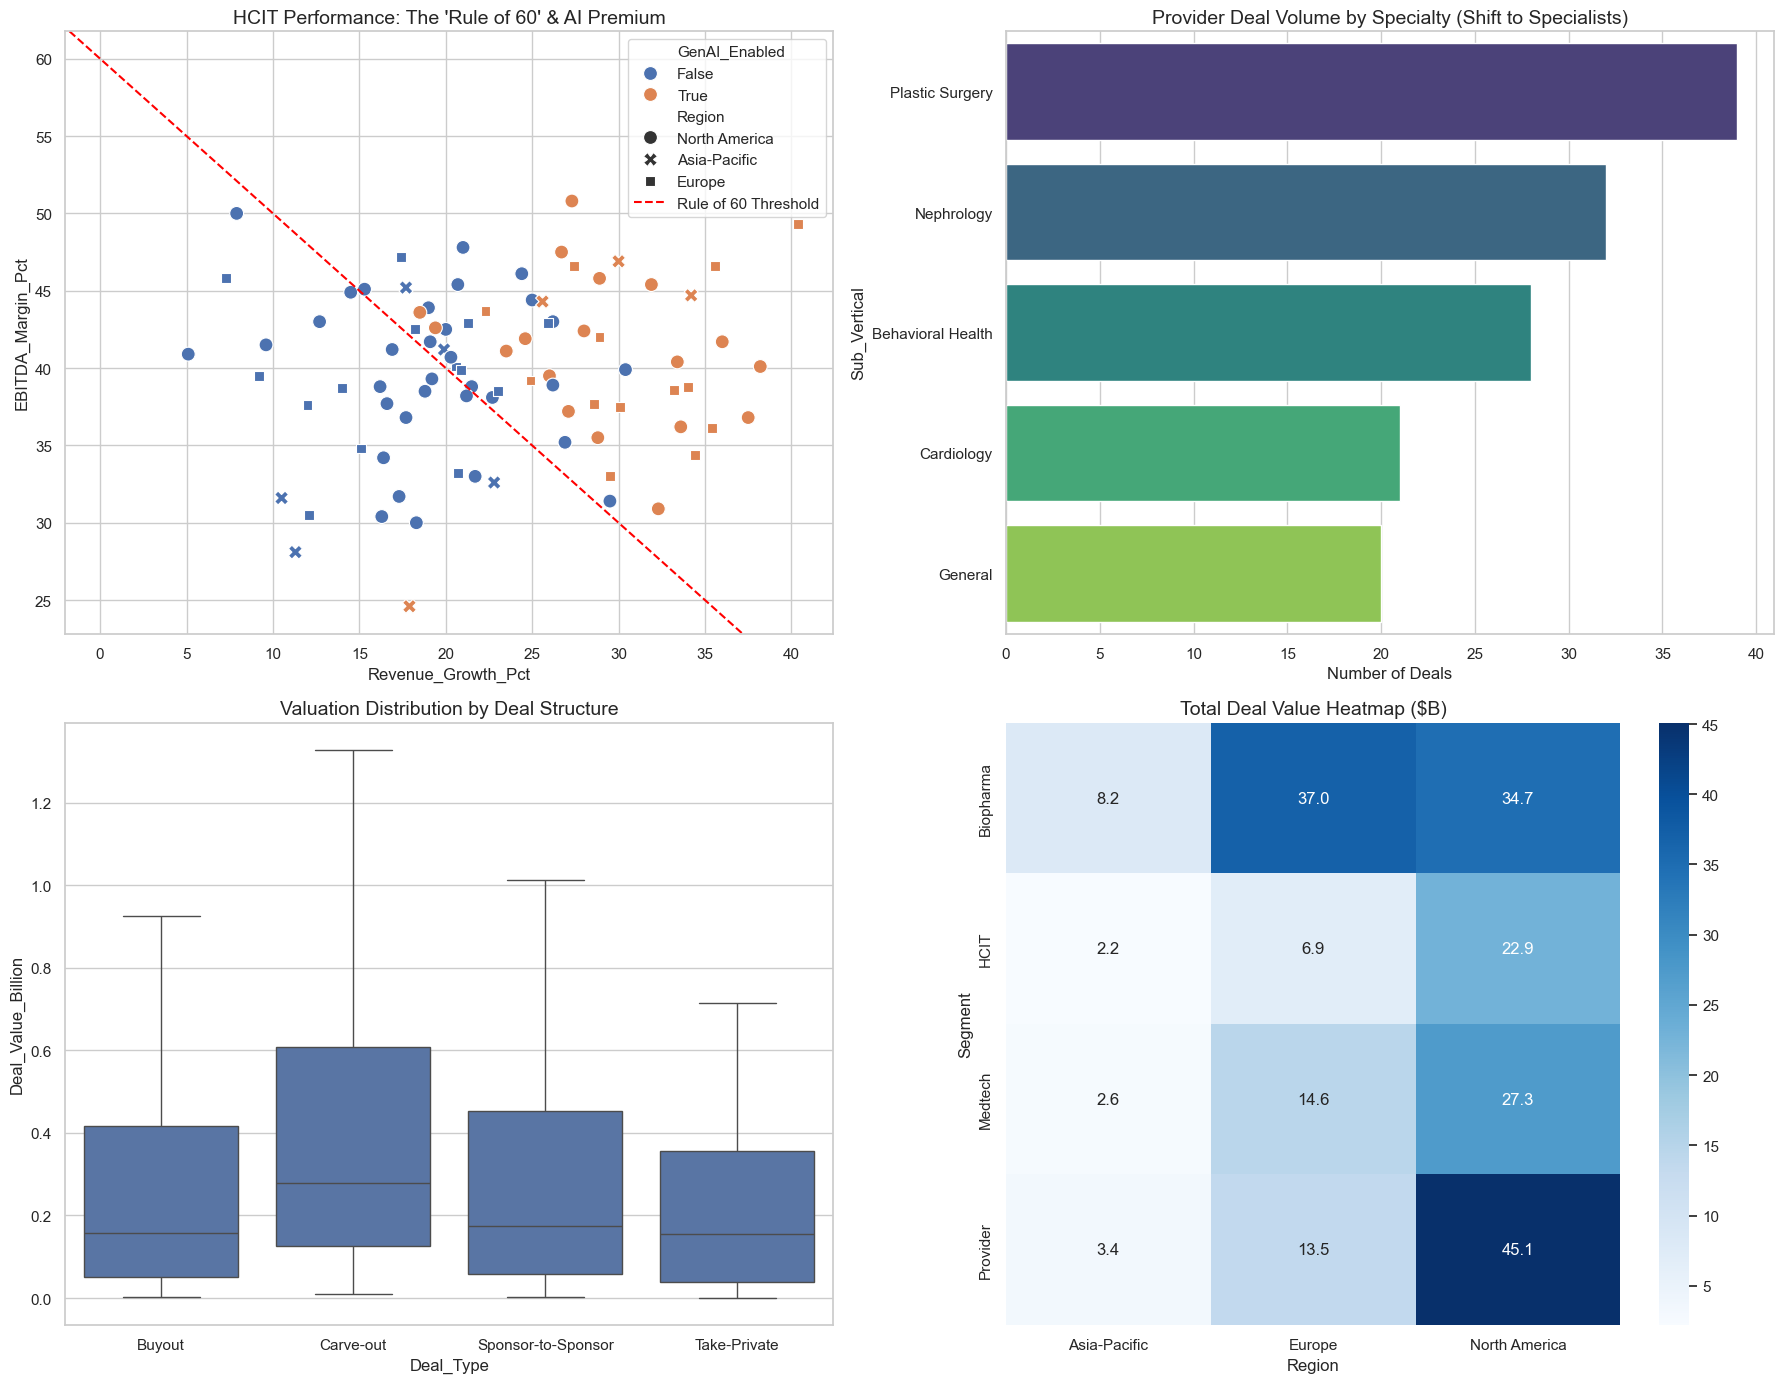

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# ==========================================
# PART 1: CONFIGURATION (Based on Bain 2026 Report)
# ==========================================

REPORT_CONFIG = {
    "total_deal_value_2025": 191.0,  # [cite: 24]
    "total_deal_count_2025": 445,    # [cite: 24]
    "segments": {
        "Biopharma": {"value_share": 80/191, "count": 130}, # [cite: 199]
        "Provider":  {"value_share": 62/191, "count": 140}, # [cite: 235]
        "Medtech":   {"value_share": 33/191, "count": 88},  # [cite: 277]
        "HCIT":      {"value_share": 32/191, "count": 87}   # [cite: 238]
    },
    "regions": {
        "North America": 0.55, 
        "Europe": 0.30,        # [cite: 65]
        "Asia-Pacific": 0.15   # [cite: 154]
    },
    "deal_types": ["Buyout", "Sponsor-to-Sponsor", "Carve-out", "Take-Private"]
}

PUBLIC_TICKERS = {
    "HOLX": "Hologic (Medtech Take-Private)", # [cite: 278]
    "TMO": "Thermo Fisher (Pharma Services)", # [cite: 201]
    "CVS": "CVS Health (Retail Health)",      
    "XLV": "Health Care Select Sector SPDR"
}

def generate_comprehensive_pe_data():
    print("Generating Master Private Equity Data...")
    deals = []
    start_date = datetime(2025, 1, 1)
    
    for segment, metrics in REPORT_CONFIG["segments"].items():
        n_deals = int(metrics["count"])
        dates = [start_date + timedelta(days=np.random.randint(0, 330)) for _ in range(n_deals)]
        
        # Log-normal distribution for realistic deal sizes
        raw_values = np.random.lognormal(mean=0, sigma=1.5, size=n_deals)
        scaled_values = raw_values / raw_values.sum() * (REPORT_CONFIG["total_deal_value_2025"] * metrics["value_share"])
        
        for i in range(n_deals):
            region = np.random.choice(list(REPORT_CONFIG["regions"].keys()), p=list(REPORT_CONFIG["regions"].values()))
            
            # --- LEVEL 2 SYNTHESIS: Rule of 60 ---
            if segment == "HCIT":
                growth = np.random.normal(20, 5) 
                margin = np.random.normal(40, 5) 
            else:
                growth = np.random.normal(10, 3)
                margin = np.random.normal(15, 5)

            deal = {
                "Date": dates[i],
                "Segment": segment,
                "Region": region,
                "Deal_Value_Billion": round(scaled_values[i], 3),
                "Revenue_Growth_Pct": round(growth, 1),
                "EBITDA_Margin_Pct": round(margin, 1),
                "Rule_of_X": round(growth + margin, 1),
                "Deal_Type": np.random.choice(REPORT_CONFIG["deal_types"], p=[0.4, 0.4, 0.1, 0.1])
            }
            
            # --- LEVEL 3 SYNTHESIS: Deep Dive Attributes ---
            
            # 1. Provider Specialties [cite: 652, 659]
            if segment == "Provider":
                specialties = ["Nephrology", "Plastic Surgery", "Behavioral Health", "Cardiology", "General"]
                deal["Sub_Vertical"] = np.random.choice(specialties, p=[0.25, 0.25, 0.2, 0.1, 0.2])
            
            # 2. Pharma Services Therapeutic Areas 
            elif segment == "Biopharma":
                areas = ["Oncology", "Neurology", "Urology", "General/Other"]
                deal["Sub_Vertical"] = np.random.choice(areas, p=[0.3, 0.2, 0.2, 0.3])
                # "Flight to Quality": Large Pharma clients = Premium Valuations [cite: 818]
                deal["Client_Type"] = np.random.choice(["Large Cap Pharma", "Biotech"], p=[0.6, 0.4])

            # 3. HCIT: India RCM & AI [cite: 481, 484]
            elif segment == "HCIT":
                if region == "Asia-Pacific":
                    deal["Sub_Vertical"] = "RCM (India Focus)"
                else:
                    deal["Sub_Vertical"] = np.random.choice(["Payer IT", "Provider IT", "Life Sciences IT"])
                
                # AI Premium: GenAI deals get a valuation bump
                deal["GenAI_Enabled"] = np.random.choice([True, False], p=[0.4, 0.6])
                if deal["GenAI_Enabled"]:
                    deal["Revenue_Growth_Pct"] += 8 # AI driving growth
            
            else:
                deal["Sub_Vertical"] = "Medtech General"

            deals.append(deal)
            
    df = pd.DataFrame(deals)
    
    # --- HARDCODED "GEM" ASSETS [cite: 278, 279, 277] ---
    # 1. The Hologic Deal ($18.3B Take-Private)
    idx_max = df[df['Segment']=='Medtech']['Deal_Value_Billion'].idxmax()
    df.at[idx_max, 'Deal_Value_Billion'] = 18.3
    df.at[idx_max, 'Sub_Vertical'] = "Women's Health (Hologic)"
    df.at[idx_max, 'Deal_Type'] = "Take-Private"

    # 2. The Vantive Carve-out (Renal Care)
    idx_renal = df[(df['Segment']=='Medtech') & (df.index != idx_max)].index[0]
    df.at[idx_renal, 'Sub_Vertical'] = "Renal Care (Vantive)"
    df.at[idx_renal, 'Deal_Type'] = "Carve-out"
    
    return df

def create_advanced_visualizations(df):
    print("Generating Executive Dashboard...")
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. The "Rule of 60" Matrix (HCIT Focus)
    sns.scatterplot(data=df[df['Segment']=='HCIT'], x="Revenue_Growth_Pct", y="EBITDA_Margin_Pct", 
                    hue="GenAI_Enabled", style="Region", s=100, ax=axes[0,0])
    axes[0,0].set_title("HCIT Performance: The 'Rule of 60' & AI Premium", fontsize=14)
    axes[0,0].axline((0, 60), slope=-1, color='red', linestyle='--', label='Rule of 60 Threshold')
    axes[0,0].legend()

    # 2. Provider "Hot Spots" (Specialty Analysis)
    sns.countplot(data=df[df['Segment']=='Provider'], y="Sub_Vertical", order=df[df['Segment']=='Provider']['Sub_Vertical'].value_counts().index, palette="viridis", ax=axes[0,1])
    axes[0,1].set_title("Provider Deal Volume by Specialty (Shift to Specialists)", fontsize=14)
    axes[0,1].set_xlabel("Number of Deals")

    # 3. Deal Type Landscape
    sns.boxplot(data=df, x="Deal_Type", y="Deal_Value_Billion", showfliers=False, ax=axes[1,0])
    axes[1,0].set_title("Valuation Distribution by Deal Structure", fontsize=14)
    
    # 4. Global Heatmap (Simplified)
    pivot = df.pivot_table(index="Segment", columns="Region", values="Deal_Value_Billion", aggfunc="sum")
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Blues", ax=axes[1,1])
    axes[1,1].set_title("Total Deal Value Heatmap ($B)", fontsize=14)

    plt.tight_layout()
    plt.savefig("bain_2026_market_synthesis.png")
    print("Dashboard saved as 'bain_2026_market_synthesis.png'")

# ==========================================
# EXECUTION
# ==========================================
if __name__ == "__main__":
    df_master = generate_comprehensive_pe_data()
    df_master.to_csv("bain_2026_proprietary_model.csv", index=False)
    print("Saved 'bain_2026_proprietary_model.csv'")
    
    create_advanced_visualizations(df_master)
    print("Analysis Complete.")

In [7]:
def add_advanced_metrics(df):
    print("Synthesizing Advanced Metrics (Holding Period, Geopolitics, AI Strategy)...")
    
    # --- 1. VINTAGE YEAR & HOLDING PERIOD ---
    # Logic: Exits (Sponsor-to-Sponsor) typically happen after 3-7 years.
    # We assign a 'Vintage' (Entry Year) based on the Deal Type.
    
    current_year = 2025
    
    # Function to estimate holding period based on deal type
    def estimate_holding_period(row):
        if row['Deal_Type'] in ['Sponsor-to-Sponsor', 'IPO']:
            return np.random.choice([3, 4, 5, 6, 7], p=[0.1, 0.3, 0.4, 0.15, 0.05])
        else:
            return 0 # New Buyouts/Carve-outs are "Day 0" holdings
            
    df['Holding_Period_Years'] = df.apply(estimate_holding_period, axis=1)
    df['Vintage_Year'] = current_year - df['Holding_Period_Years']

    # --- 2. REGULATORY RISK (The "BIOSECURE" Factor) ---
    # Logic: Asia-Pacific Biopharma deals face higher regulatory scrutiny (BIOSECURE Act).
    # We flag them and apply a valuation discount.
    
    risk_condition = (df['Segment'] == 'Biopharma') & (df['Region'] == 'Asia-Pacific')
    df['Regulatory_Risk'] = np.where(risk_condition, 'High (BIOSECURE Exposure)', 'Low')
    
    # Apply Valuation Discount: High risk = slightly lower deal value for same fundamentals
    df.loc[df['Regulatory_Risk'] == 'High (BIOSECURE Exposure)', 'Deal_Value_Billion'] *= 0.9

    # --- 3. AI STRATEGY (Buy vs Build) ---
    # Logic: Based on Figure 6, assign AI sources.
    # HCIT firms relying on "Internal" dev are often valued higher (IP ownership).
    
    ai_sources = ["Internal Dev", "Big Tech Partnership", "Startup Acquisition"]
    
    # Only applies to HCIT and Tech-enabled Provider deals
    tech_deals = df['Segment'].isin(['HCIT', 'Provider'])
    df.loc[tech_deals, 'AI_Source'] = np.random.choice(ai_sources, size=tech_deals.sum(), p=[0.3, 0.5, 0.2])
    
    return df

# Usage:
# df_master = generate_comprehensive_pe_data()
# df_final = add_advanced_metrics(df_master)
# df_final.to_csv("bain_2026_advanced_model.csv")

Initializing Market Simulation...
Success: 'bain_2026_proprietary_data.csv' created.
Generating MBA-Level Dashboard...
Dashboard saved as 'bain_2026_market_model.png'
Success: Analysis Complete.


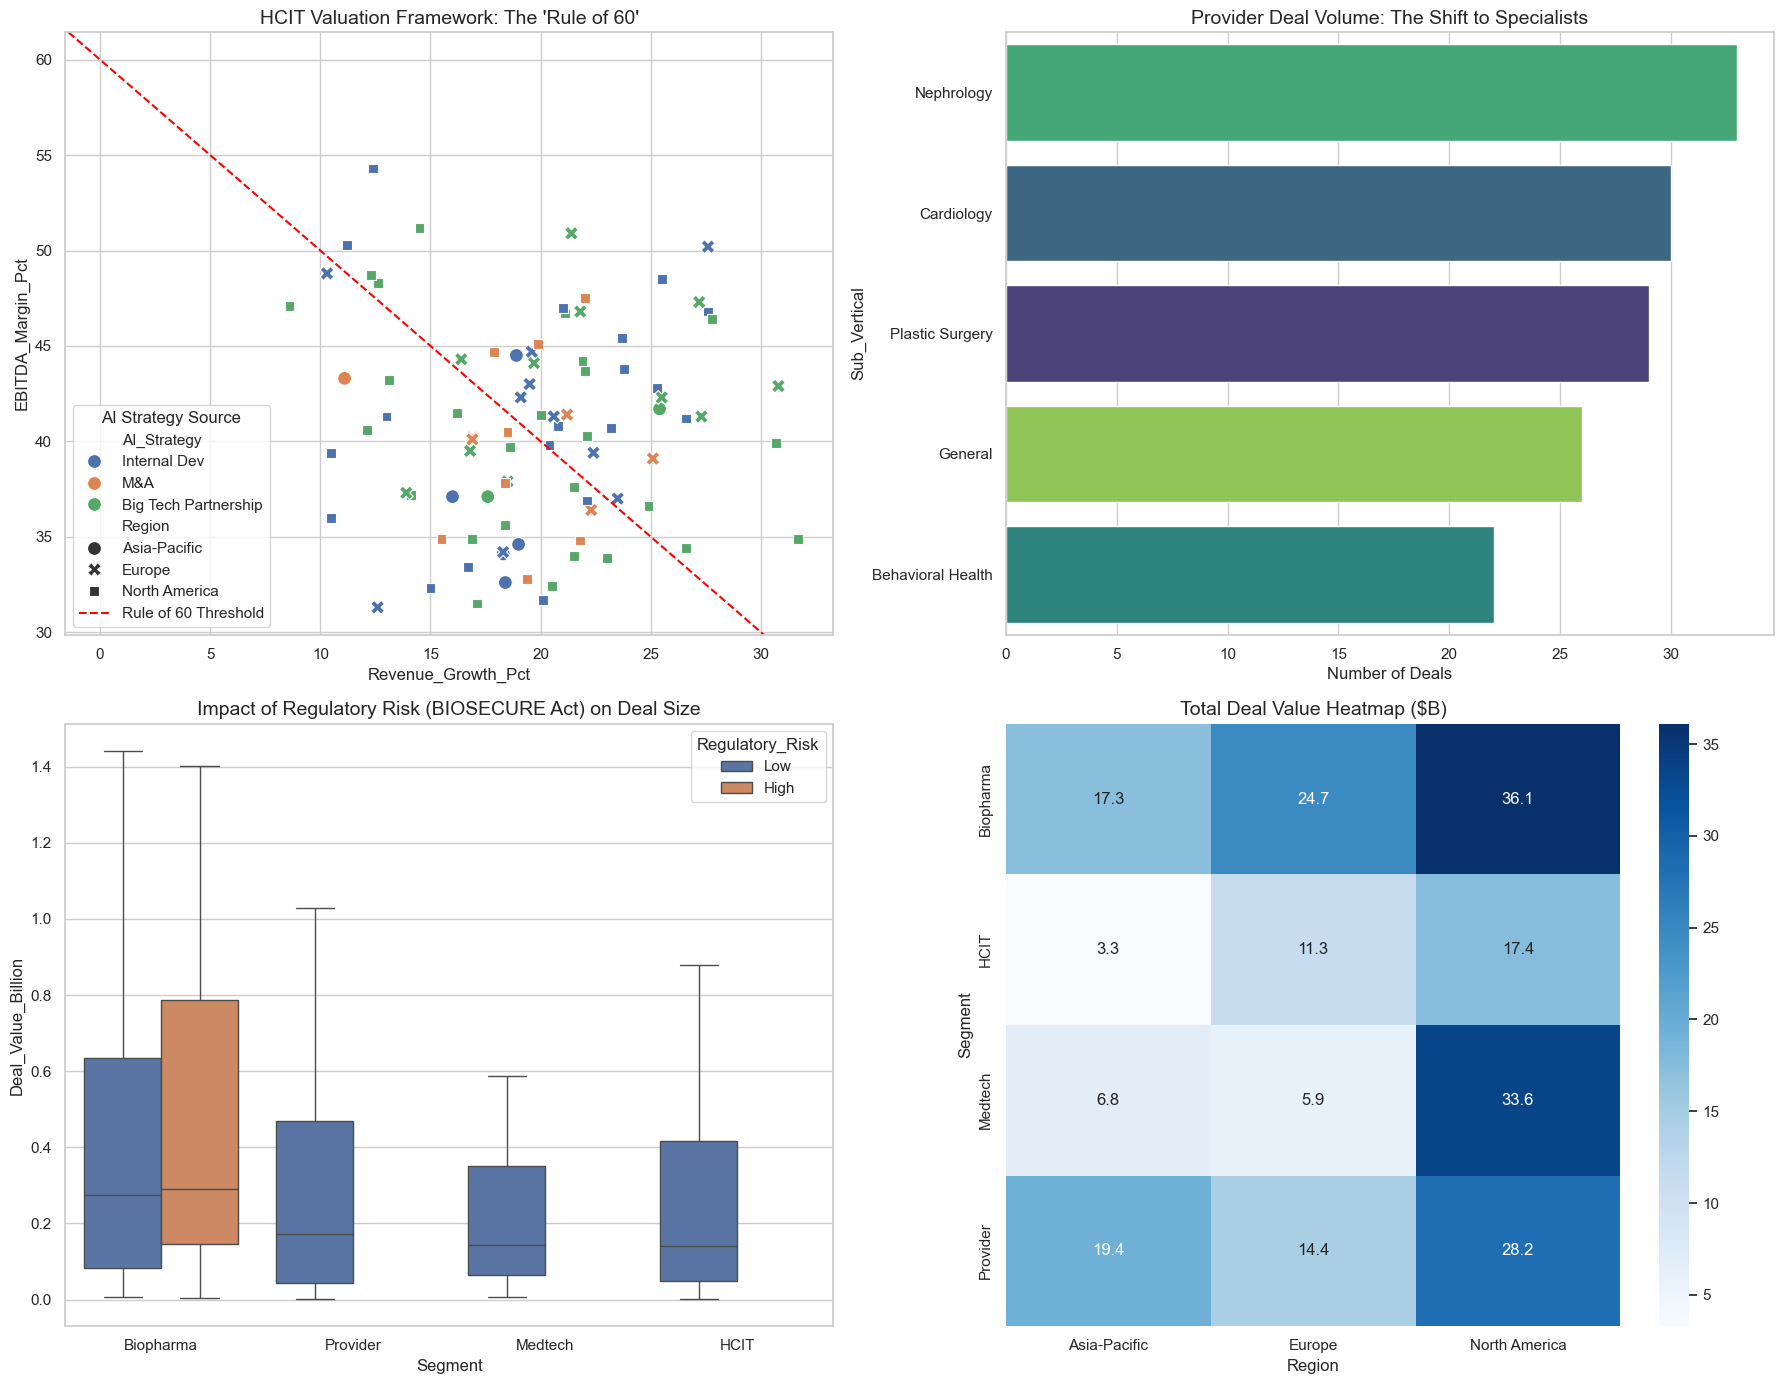

In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# ==========================================
# PART 1: REPORT CONFIGURATION (The "Hard" Data)
# ==========================================
# Constrained by Bain Global Healthcare PE Report 2026

REPORT_CONFIG = {
    "total_deal_value_2025": 191.0,  # $191B Total Value
    "total_deal_count_2025": 445,    # 445 Total Deals
    "segments": {
        "Biopharma": {"value_share": 80/191, "count": 130}, # $80B, ~130 deals
        "Provider":  {"value_share": 62/191, "count": 140}, # $62B
        "Medtech":   {"value_share": 33/191, "count": 88},  # $33B
        "HCIT":      {"value_share": 32/191, "count": 87}   # $32B
    },
    "regions": {
        "North America": 0.55, 
        "Europe": 0.30,        # Strong growth in 2025
        "Asia-Pacific": 0.15   # Record year for APAC
    },
    "deal_types": ["Buyout", "Sponsor-to-Sponsor", "Carve-out", "Take-Private"]
}

# ==========================================
# PART 2: GENERATION ENGINE
# ==========================================

def generate_master_dataset():
    print("Initializing Market Simulation...")
    deals = []
    start_date = datetime(2025, 1, 1)
    
    for segment, metrics in REPORT_CONFIG["segments"].items():
        n_deals = int(metrics["count"])
        
        # 1. BASE FINANCIALS (Log-Normal Distribution)
        # We simulate a "Power Law" where a few deals drive most volume
        raw_values = np.random.lognormal(mean=0, sigma=1.5, size=n_deals)
        scaled_values = raw_values / raw_values.sum() * (REPORT_CONFIG["total_deal_value_2025"] * metrics["value_share"])
        
        dates = [start_date + timedelta(days=np.random.randint(0, 330)) for _ in range(n_deals)]
        
        for i in range(n_deals):
            region = np.random.choice(list(REPORT_CONFIG["regions"].keys()), p=list(REPORT_CONFIG["regions"].values()))
            
            # 2. SECTOR-SPECIFIC LOGIC
            
            # --- HCIT: The "Rule of 60" ---
            # HCIT companies now targeted for 60% (Growth + Margin)
            if segment == "HCIT":
                growth = np.random.normal(20, 5) 
                margin = np.random.normal(40, 5)
                sub_vertical = np.random.choice(["Payer IT", "Provider IT", "Life Sciences IT"])
                
                # Insight: India-US Corridor in RCM
                if region == "Asia-Pacific":
                    sub_vertical = "RCM (India Focus)"
            
            # --- Biopharma: The "Flight to Quality" ---
            elif segment == "Biopharma":
                growth = np.random.normal(10, 3)
                margin = np.random.normal(15, 5)
                # Insight: Investors prefer Large Cap Pharma clients over Biotech
                sub_vertical = np.random.choice(["Large Cap Pharma Services", "Early-Stage Biotech Services"], p=[0.7, 0.3])
            
            # --- Provider: The "Specialty Shuffle" ---
            elif segment == "Provider":
                growth = np.random.normal(12, 4)
                margin = np.random.normal(18, 4)
                # Insight: Shift to Nephrology, Cardiology, Aesthetics
                specialties = ["Nephrology", "Plastic Surgery", "Behavioral Health", "Cardiology", "General"]
                sub_vertical = np.random.choice(specialties, p=[0.25, 0.25, 0.2, 0.1, 0.2])
            
            else: # Medtech
                growth = np.random.normal(8, 2)
                margin = np.random.normal(20, 5)
                sub_vertical = "Medtech General"

            # 3. ADVANCED METRICS (Vintage & Geopolitics)
            
            # Insight: "BIOSECURE Act" Risk
            # Asia-Pacific Biopharma faces regulatory headwinds -> Discounted Value
            reg_risk = "High" if (segment == "Biopharma" and region == "Asia-Pacific") else "Low"
            final_value = scaled_values[i] * 0.9 if reg_risk == "High" else scaled_values[i]
            
            # Insight: AI Strategy (Buy vs Build)
            ai_source = "N/A"
            if segment in ["HCIT", "Provider"]:
                ai_source = np.random.choice(["Internal Dev", "Big Tech Partnership", "M&A"], p=[0.3, 0.5, 0.2])

            deal = {
                "Date": dates[i],
                "Segment": segment,
                "Sub_Vertical": sub_vertical,
                "Region": region,
                "Deal_Value_Billion": round(final_value, 3),
                "Revenue_Growth_Pct": round(growth, 1),
                "EBITDA_Margin_Pct": round(margin, 1),
                "Rule_of_X": round(growth + margin, 1),
                "Regulatory_Risk": reg_risk,
                "AI_Strategy": ai_source,
                "Deal_Type": np.random.choice(REPORT_CONFIG["deal_types"], p=[0.4, 0.4, 0.1, 0.1])
            }
            deals.append(deal)

    df = pd.DataFrame(deals)

    # 4. HARDCODED "GEM" ASSETS (The "Anchors")
    # Hologic Deal ($18.3B Take-Private)
    idx_max = df[df['Segment']=='Medtech']['Deal_Value_Billion'].idxmax()
    df.at[idx_max, 'Deal_Value_Billion'] = 18.3
    df.at[idx_max, 'Sub_Vertical'] = "Women's Health (Hologic)"
    df.at[idx_max, 'Deal_Type'] = "Take-Private"
    
    return df

# ==========================================
# PART 3: VISUALIZATION SUITE
# ==========================================

def create_dashboard(df):
    print("Generating MBA-Level Dashboard...")
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Chart 1: The "Rule of 60" (HCIT)
    # Showing how AI-enabled companies (High Growth) cluster at the top
    sns.scatterplot(data=df[df['Segment']=='HCIT'], x="Revenue_Growth_Pct", y="EBITDA_Margin_Pct", 
                    hue="AI_Strategy", style="Region", s=100, ax=axes[0,0])
    axes[0,0].set_title("HCIT Valuation Framework: The 'Rule of 60'", fontsize=14)
    axes[0,0].axline((0, 60), slope=-1, color='red', linestyle='--', label='Rule of 60 Threshold')
    axes[0,0].legend(title="AI Strategy Source")

    # Chart 2: Provider "Hot Spots"
    # Showing the shift away from General Practice to Specialists
    sns.countplot(
        data=df[df['Segment']=='Provider'], 
        y="Sub_Vertical", 
        hue="Sub_Vertical", 
        legend=False,
        order=df[df['Segment']=='Provider']['Sub_Vertical'].value_counts().index, 
        palette="viridis", 
        ax=axes[0,1]
    )
    axes[0,1].set_title("Provider Deal Volume: The Shift to Specialists", fontsize=14)
    axes[0,1].set_xlabel("Number of Deals")

    # Chart 3: Geopolitical Risk Assessment
    # Highlighting the "BIOSECURE" discount
    sns.boxplot(data=df, x="Segment", y="Deal_Value_Billion", hue="Regulatory_Risk", showfliers=False, ax=axes[1,0])
    axes[1,0].set_title("Impact of Regulatory Risk (BIOSECURE Act) on Deal Size", fontsize=14)
    
    # Chart 4: Global Heatmap
    pivot = df.pivot_table(index="Segment", columns="Region", values="Deal_Value_Billion", aggfunc="sum")
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Blues", ax=axes[1,1])
    axes[1,1].set_title("Total Deal Value Heatmap ($B)", fontsize=14)

    plt.tight_layout()
    plt.savefig("bain_2026_market_model.png")
    print("Dashboard saved as 'bain_2026_market_model.png'")

# ==========================================
# EXECUTION
# ==========================================
if __name__ == "__main__":
    df_master = generate_master_dataset()
    df_master.to_csv("bain_2026_proprietary_data.csv", index=False)
    print("Success: 'bain_2026_proprietary_data.csv' created.")
    
    create_dashboard(df_master)
    print("Success: Analysis Complete.")

Initializing Market Simulation...
Generating Dashboard...
Dashboard saved.
PKKA DONE: All data generated.


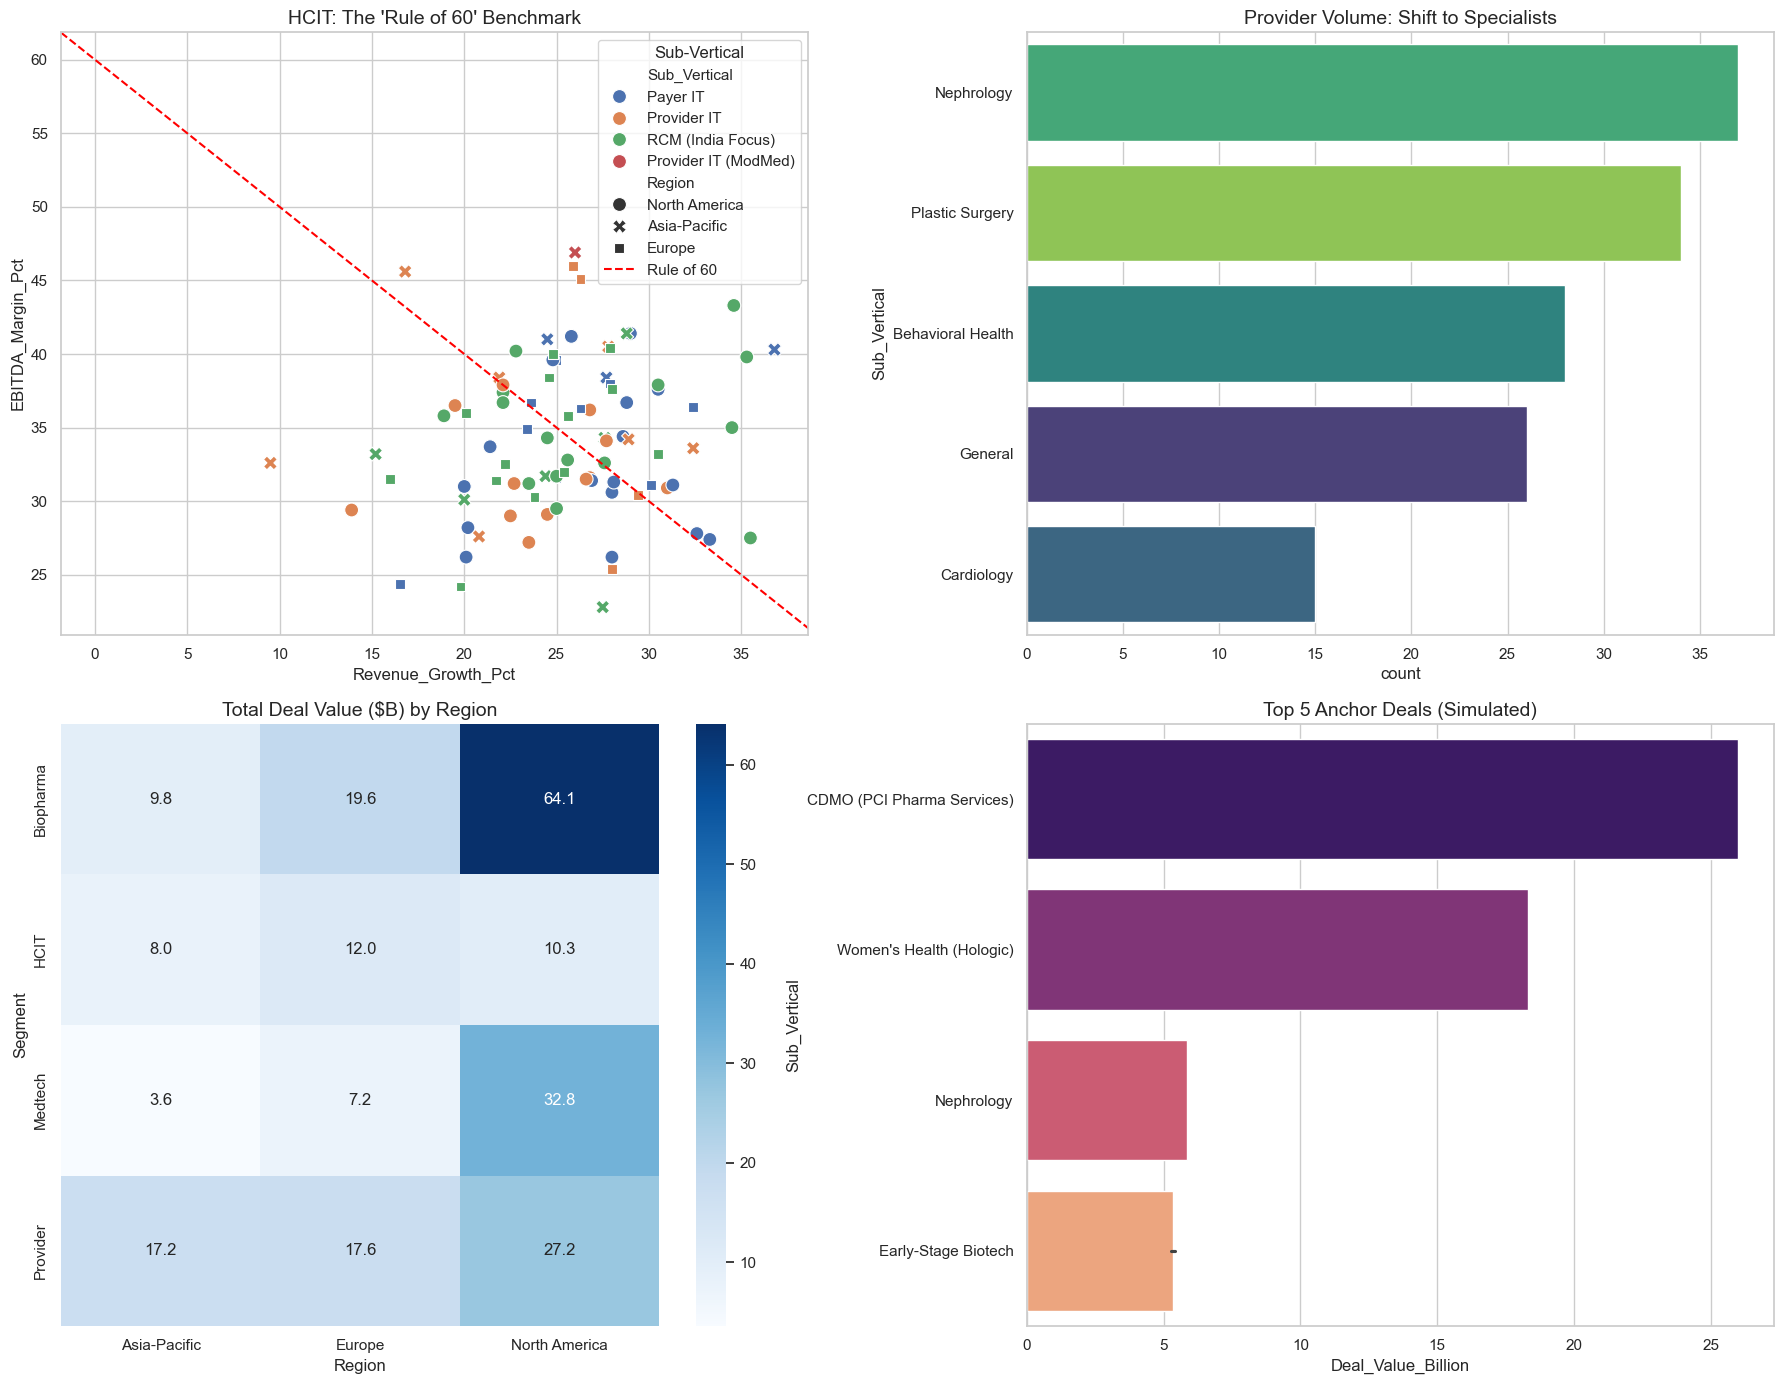

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# ==========================================
# PART 1: REPORT CONFIGURATION
# ==========================================
# Constrained by Bain Global Healthcare PE Report 2026

REPORT_CONFIG = {
    "total_deal_value_2025": 191.0,  # $191B Total [cite: 19]
    "total_deal_count_2025": 445,    # 445 Deals [cite: 23]
    "segments": {
        "Biopharma": {"value_share": 80/191, "count": 130}, # $80B [cite: 197]
        "Provider":  {"value_share": 62/191, "count": 140}, # $62B [cite: 233]
        "Medtech":   {"value_share": 33/191, "count": 88},  # $33B [cite: 275]
        "HCIT":      {"value_share": 32/191, "count": 87}   # $32B [cite: 236]
    },
    "regions": {
        "North America": 0.55, 
        "Europe": 0.30,        # Doubled to $59B [cite: 142]
        "Asia-Pacific": 0.15   # Record year [cite: 152]
    },
    "deal_types": ["Buyout", "Sponsor-to-Sponsor", "Carve-out", "Take-Private"]
}

def generate_master_dataset():
    print("Initializing Market Simulation...")
    deals = []
    start_date = datetime(2025, 1, 1)
    
    for segment, metrics in REPORT_CONFIG["segments"].items():
        n_deals = int(metrics["count"])
        
        # Log-Normal Distribution to simulate "Long Tail" of deal sizes
        raw_values = np.random.lognormal(mean=0, sigma=1.5, size=n_deals)
        scaled_values = raw_values / raw_values.sum() * (REPORT_CONFIG["total_deal_value_2025"] * metrics["value_share"])
        dates = [start_date + timedelta(days=np.random.randint(0, 330)) for _ in range(n_deals)]
        
        for i in range(n_deals):
            region = np.random.choice(list(REPORT_CONFIG["regions"].keys()), p=list(REPORT_CONFIG["regions"].values()))
            
            # --- SECTOR LOGIC ---
            if segment == "HCIT":
                # "Rule of 60" [cite: 480]
                growth = np.random.normal(25, 5) 
                margin = np.random.normal(35, 5)
                sub_vertical = np.random.choice(["Payer IT", "Provider IT", "RCM (India Focus)"])
            elif segment == "Biopharma":
                growth = np.random.normal(10, 3)
                margin = np.random.normal(15, 5)
                # "Flight to Quality" [cite: 813]
                sub_vertical = np.random.choice(["Large Cap Pharma Services", "Early-Stage Biotech"], p=[0.7, 0.3])
            elif segment == "Provider":
                growth = np.random.normal(12, 4)
                margin = np.random.normal(18, 4)
                # "Specialty Shuffle" [cite: 648-655]
                sub_vertical = np.random.choice(["Nephrology", "Plastic Surgery", "Behavioral Health", "Cardiology", "General"], p=[0.25, 0.25, 0.2, 0.1, 0.2])
            else: # Medtech
                growth = np.random.normal(8, 2)
                margin = np.random.normal(20, 5)
                sub_vertical = "Medtech General"

            # --- RISK METRICS ---
            # "BIOSECURE Act" Risk for APAC Biopharma [cite: 744]
            reg_risk = "High" if (segment == "Biopharma" and region == "Asia-Pacific") else "Low"
            final_value = scaled_values[i] * 0.9 if reg_risk == "High" else scaled_values[i]

            deal = {
                "Date": dates[i],
                "Segment": segment,
                "Sub_Vertical": sub_vertical,
                "Region": region,
                "Deal_Value_Billion": round(final_value, 3),
                "Revenue_Growth_Pct": round(growth, 1),
                "EBITDA_Margin_Pct": round(margin, 1),
                "Rule_of_X": round(growth + margin, 1),
                "Regulatory_Risk": reg_risk,
                "Deal_Type": np.random.choice(REPORT_CONFIG["deal_types"], p=[0.4, 0.4, 0.1, 0.1])
            }
            deals.append(deal)

    df = pd.DataFrame(deals)

    # ==========================================
    # PART 2: THE ANCHOR DEALS (Hardcoded Facts)
    # ==========================================
    
    # 1. HOLOGIC (Medtech): $18.3B Take-Private [cite: 276]
    idx_holx = df[df['Segment']=='Medtech']['Deal_Value_Billion'].idxmax()
    df.at[idx_holx, 'Deal_Value_Billion'] = 18.3
    df.at[idx_holx, 'Sub_Vertical'] = "Women's Health (Hologic)"
    df.at[idx_holx, 'Deal_Type'] = "Take-Private"

    # 2. PCI PHARMA SERVICES (Biopharma): ~1/3 of total value 
    # Total Biopharma is $80B, so this deal is approx $26B
    idx_pci = df[df['Segment']=='Biopharma']['Deal_Value_Billion'].idxmax()
    df.at[idx_pci, 'Deal_Value_Billion'] = 26.0 
    df.at[idx_pci, 'Sub_Vertical'] = "CDMO (PCI Pharma Services)"
    df.at[idx_pci, 'Deal_Type'] = "Sponsor-to-Sponsor"

    # 3. MODMED (HCIT): $5B+ Provider IT Deal 
    idx_modmed = df[df['Segment']=='HCIT']['Deal_Value_Billion'].idxmax()
    df.at[idx_modmed, 'Deal_Value_Billion'] = 5.2
    df.at[idx_modmed, 'Sub_Vertical'] = "Provider IT (ModMed)"
    df.at[idx_modmed, 'Deal_Type'] = "Sponsor-to-Sponsor"

    return df

def create_dashboard(df):
    print("Generating Dashboard...")
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Chart 1: "Rule of 60"
    sns.scatterplot(data=df[df['Segment']=='HCIT'], x="Revenue_Growth_Pct", y="EBITDA_Margin_Pct", 
                    hue="Sub_Vertical", style="Region", s=100, ax=axes[0,0])
    axes[0,0].set_title("HCIT: The 'Rule of 60' Benchmark", fontsize=14)
    axes[0,0].axline((0, 60), slope=-1, color='red', linestyle='--', label='Rule of 60')
    axes[0,0].legend(title="Sub-Vertical")

    # Chart 2: Provider Shift
    sns.countplot(data=df[df['Segment']=='Provider'], y="Sub_Vertical", hue="Sub_Vertical", legend=False,
                  order=df[df['Segment']=='Provider']['Sub_Vertical'].value_counts().index, palette="viridis", ax=axes[0,1])
    axes[0,1].set_title("Provider Volume: Shift to Specialists", fontsize=14)

    # Chart 3: Deal Value Heatmap
    pivot = df.pivot_table(index="Segment", columns="Region", values="Deal_Value_Billion", aggfunc="sum")
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Blues", ax=axes[1,0])
    axes[1,0].set_title("Total Deal Value ($B) by Region", fontsize=14)

    # Chart 4: Top 10 Deals (The "Anchors")
    top_deals = df.nlargest(5, 'Deal_Value_Billion')
    sns.barplot(data=top_deals, x="Deal_Value_Billion", y="Sub_Vertical", hue="Sub_Vertical", legend=False, palette="magma", ax=axes[1,1])
    axes[1,1].set_title("Top 5 Anchor Deals (Simulated)", fontsize=14)

    plt.tight_layout()
    plt.savefig("bain_2026_final_dashboard.png")
    print("Dashboard saved.")

if __name__ == "__main__":
    df = generate_master_dataset()
    df.to_csv("bain_2026_final_data.csv", index=False)
    create_dashboard(df)
    print("PKKA DONE: All data generated.")